In [ ]:
from itertools import product
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr

# Data Loading and Preprocessing

In [258]:
PROJECT_PATH = Path(".")

DATA_PATH = PROJECT_PATH / "data"
DATA_RAW_PATH = DATA_PATH / "01_raw"

CHLOROPHYLL_DATA_PATH = (
    DATA_RAW_PATH / "chl_cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D.nc"
)

CHLOROPHYLL_DATA_PATH

WindowsPath('data/01_raw/chl_cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D.nc')

We open the dataset. For convenience, we will change the names of the "longitude" and "latitude" columns to "lon" and "lat" respectively.

In [259]:
ds = xr.open_dataset(CHLOROPHYLL_DATA_PATH, engine="netcdf4")
ds = ds.rename({"longitude": "lon", "latitude": "lat"})

lat_min, lat_max = float(ds.lat.min()), float(ds.lat.max())
lon_min, lon_max = float(ds.lon.min()), float(ds.lon.max())
boundaries = (lon_min, lat_min, lon_max, lat_max)
centroid = ((lat_min + lat_max) / 2, (lon_min + lon_max) / 2)

print(ds)

<xarray.Dataset> Size: 635MB
Dimensions:  (time: 9842, lat: 168, lon: 96)
Coordinates:
  * lat      (lat) float32 672B -27.98 -27.94 -27.9 ... -21.1 -21.06 -21.02
  * lon      (lon) float32 384B -72.98 -72.94 -72.9 ... -69.1 -69.06 -69.02
  * time     (time) datetime64[ns] 79kB 1997-09-04 1997-09-05 ... 2024-08-14
Data variables:
    CHL      (time, lat, lon) float32 635MB ...
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    ...                              ...
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-11-20T15:24:55Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my

We start with a preliminary visualization of the data in your region.

In [260]:
# Get the quantiles of chlorophyll-a concentration
q_01, q_99 = ds["CHL"].quantile([0.01, 0.99], method="closest_observation").values
print(f"Quantiles: {q_01 = :.2f}, {q_99 = :.2f}")

Quantiles: q_01 = 0.11, q_99 = 4.46


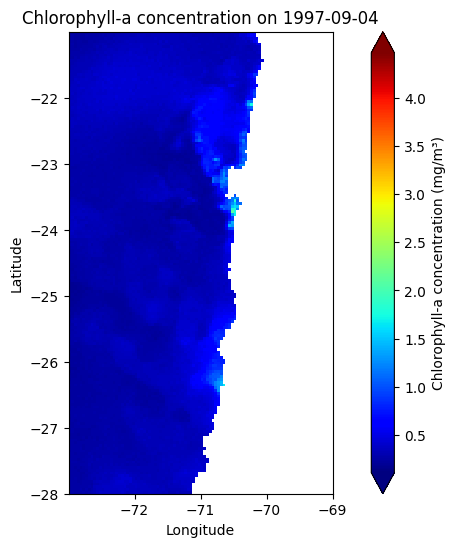

In [261]:
from matplotlib.figure import Figure
from matplotlib.axes import Axes


def plot_chlorophyll(
    ds: xr.Dataset,
    time_index: int,
    fig: Figure = None,
    ax: Axes = None,
    title: str | None = None,
    colorbar: bool = True,
    vmin: float = q_01,
    vmax: float = q_99,
    cmap: str = "jet",
) -> tuple[Figure, Axes]:
    """
    Plot chlorophyll-a concentration from a dataset.

    :param ds: xarray dataset containing chlorophyll-a data.
    :param time_index: Index of the time dimension to plot. Must be an integer.
    :param fig: Matplotlib figure object. If None, a new figure is created.
    :param ax: Matplotlib axes object. If None, a new axes is created.
    :param title: Title of the plot. If None, a default title is generated.
    :param colorbar: Whether to display a colorbar. Default is True.
    :param vmin: Minimum value for color mapping. Default is the 1st percentile of chlorophyll-a data.
    :param vmax: Maximum value for color mapping. Default is the 99th percentile of chlorophyll-a data.
    :param cmap: Colormap to use for the plot. Default is "jet".
    :return: Tuple of the figure and axes objects.
    """

    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    lat = ds.lat.data
    lon = ds.lon.data
    chl = ds.CHL.data

    pcolormesh_kwargs = dict(shading="auto", cmap=cmap)

    pcolormesh_kwargs["vmin"] = vmin
    pcolormesh_kwargs["vmax"] = vmax

    mesh = ax.pcolormesh(lon, lat, chl[time_index, :, :], **pcolormesh_kwargs)

    if colorbar:
        colorbar_kwargs = dict(ax=ax, label="Chlorophyll-a concentration (mg/m³)")

        colorbar_kwargs["extend"] = "both"
        cbar = fig.colorbar(mesh, **colorbar_kwargs)
        cbar.cmap.set_under("gray")
        cbar.cmap.set_over("magenta")

    title = (
        title
        or f"Chlorophyll-a concentration on {str(ds.time[time_index].values)[:10]}"
    )

    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    ax.set_aspect("equal", adjustable="box")

    return fig, ax


plot_chlorophyll(ds, 0)
plt.show()

We can observe that at first, there is a large amount of missing data in a certain region. Let's check with Google Earth Engine how that region looks like.


In [ ]:
%%script false --no-raise-error
import ee
import geemap


ee.Authenticate()
ee.Initialize()

region = ee.Geometry.Rectangle(boundaries)


def mask_clouds(image):
    # Select the QA60 band and create a cloud mask
    qa = image.select("QA60")
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    # Apply the cloud mask to the image
    return image.updateMask(mask).divide(10000)


# Select the Sentinel-2 image collection
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(region)
    .filterDate("2021-01-01", "2021-12-31")
    .map(mask_clouds)
)

vis_params = dict(bands=["B4", "B3", "B2"], min=0, max=0.3)

Map = geemap.Map(center=centroid, zoom=6)

Map.addLayer(collection.mosaic().clip(region), vis_params, "Sentinel-2 Copernicus")
Map.addLayer(region, {}, "Region of Interest")
Map.addLayerControl()

Map

Couldn't find program: 'false'


We can see that indeed the region that has missing values in the time series is the one that corresponds to the coast, at least the region that is systematically missing. Now let's review some images over the days to see if there is any missing data in between.

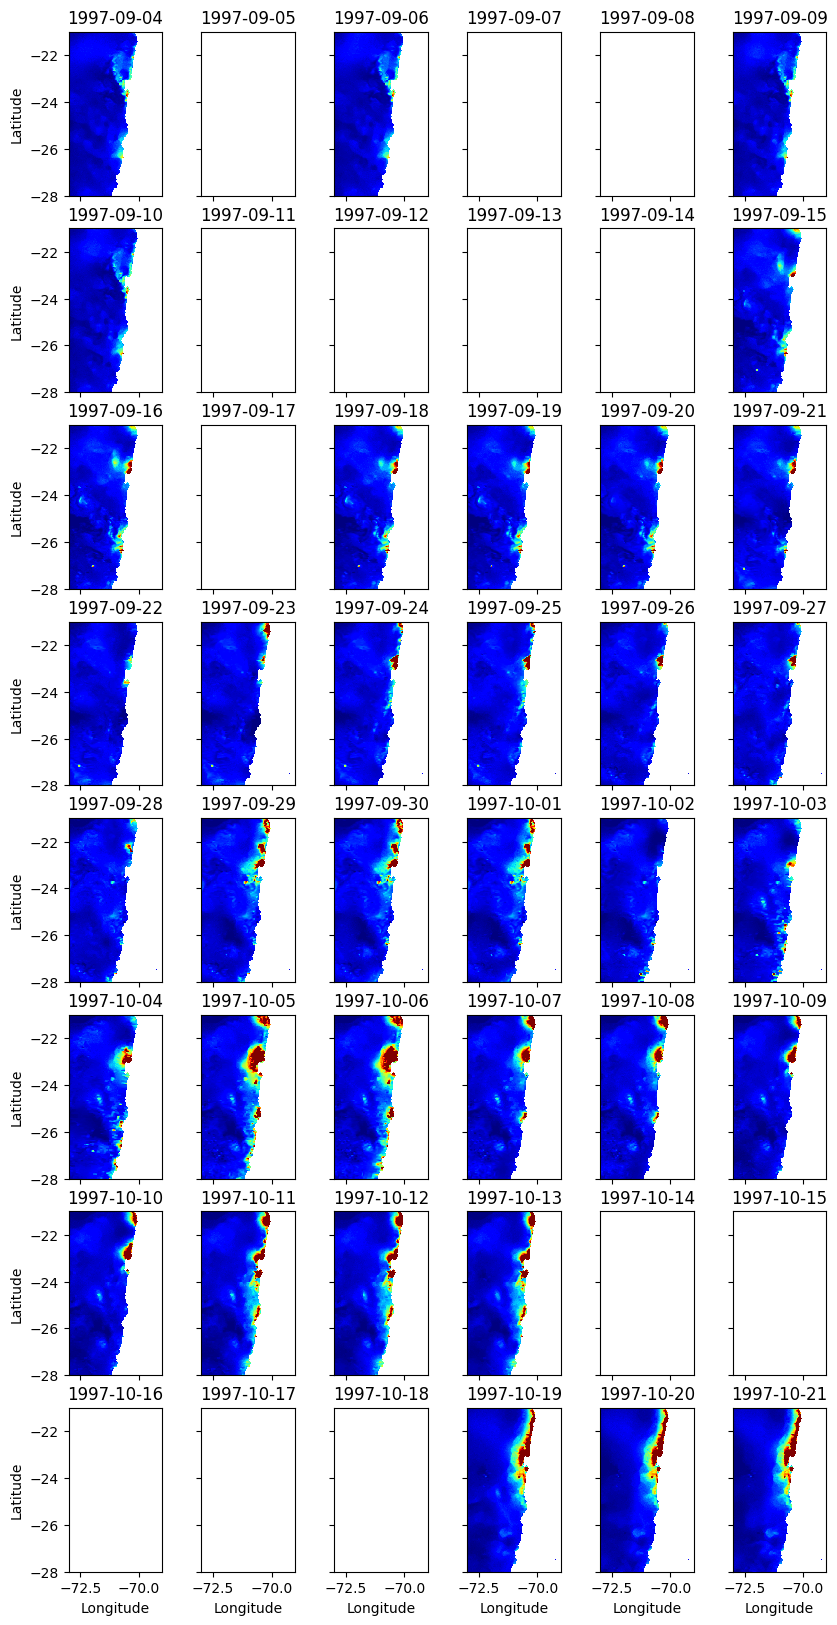

In [263]:
def plot_chlorophyll_grid(
    ds: xr.Dataset, n_row: int = 8, n_col: int = 6
) -> tuple[Figure, Axes]:
    """
    Plot a grid of the first n_row * n_col chlorophyll-a concentration images
    from a dataset.

    :param ds: xarray dataset containing chlorophyll-a data.
    :param n_row: Number of rows in the grid. Default is 8.
    :param n_col: Number of columns in the grid. Default is 6.
    :return: Tuple of the figure and axes objects.
    """

    fig, axs = plt.subplots(n_row, n_col, figsize=(10, 20))

    ds = ds.sel(time=ds.time[: n_row * n_col])
    q_01, q_99 = ds["CHL"].quantile([0.01, 0.99], method="closest_observation").values

    for i, j in product(range(n_row), range(n_col)):
        time_index = i * n_col + j
        plot_chlorophyll(
            ds,
            time_index,
            fig,
            axs[i, j],
            colorbar=False,
            title=f"{str(ds.time[time_index].values)[:10]}",
            vmin=q_01,
            vmax=q_99,
        )

        if j != 0:
            axs[i, j].set_ylabel("")
            axs[i, j].set_yticklabels([])

        if i != n_row - 1:
            axs[i, j].set_xlabel("")
            axs[i, j].set_xticklabels([])

    return fig, axs


plot_chlorophyll_grid(ds, n_row=8, n_col=6)
plt.show()

Indeed, there are times when there is no data. Let's choose some coordinate inside and check how the missing data is distributed over time.

In [264]:
chl_da = ds["CHL"].sel(lat=-24, lon=-72, method="nearest")
chl_np = chl_da.values

In [265]:
# Let's check the number of NaN values in the array
print(
    f"Number of NaN values: {int(np.isnan(chl_np).sum())} / {chl_np.size} "
    f"({float(np.isnan(chl_np).sum() / chl_np.size * 100):.2f}%)"
)

Number of NaN values: 24 / 9842 (0.24%)


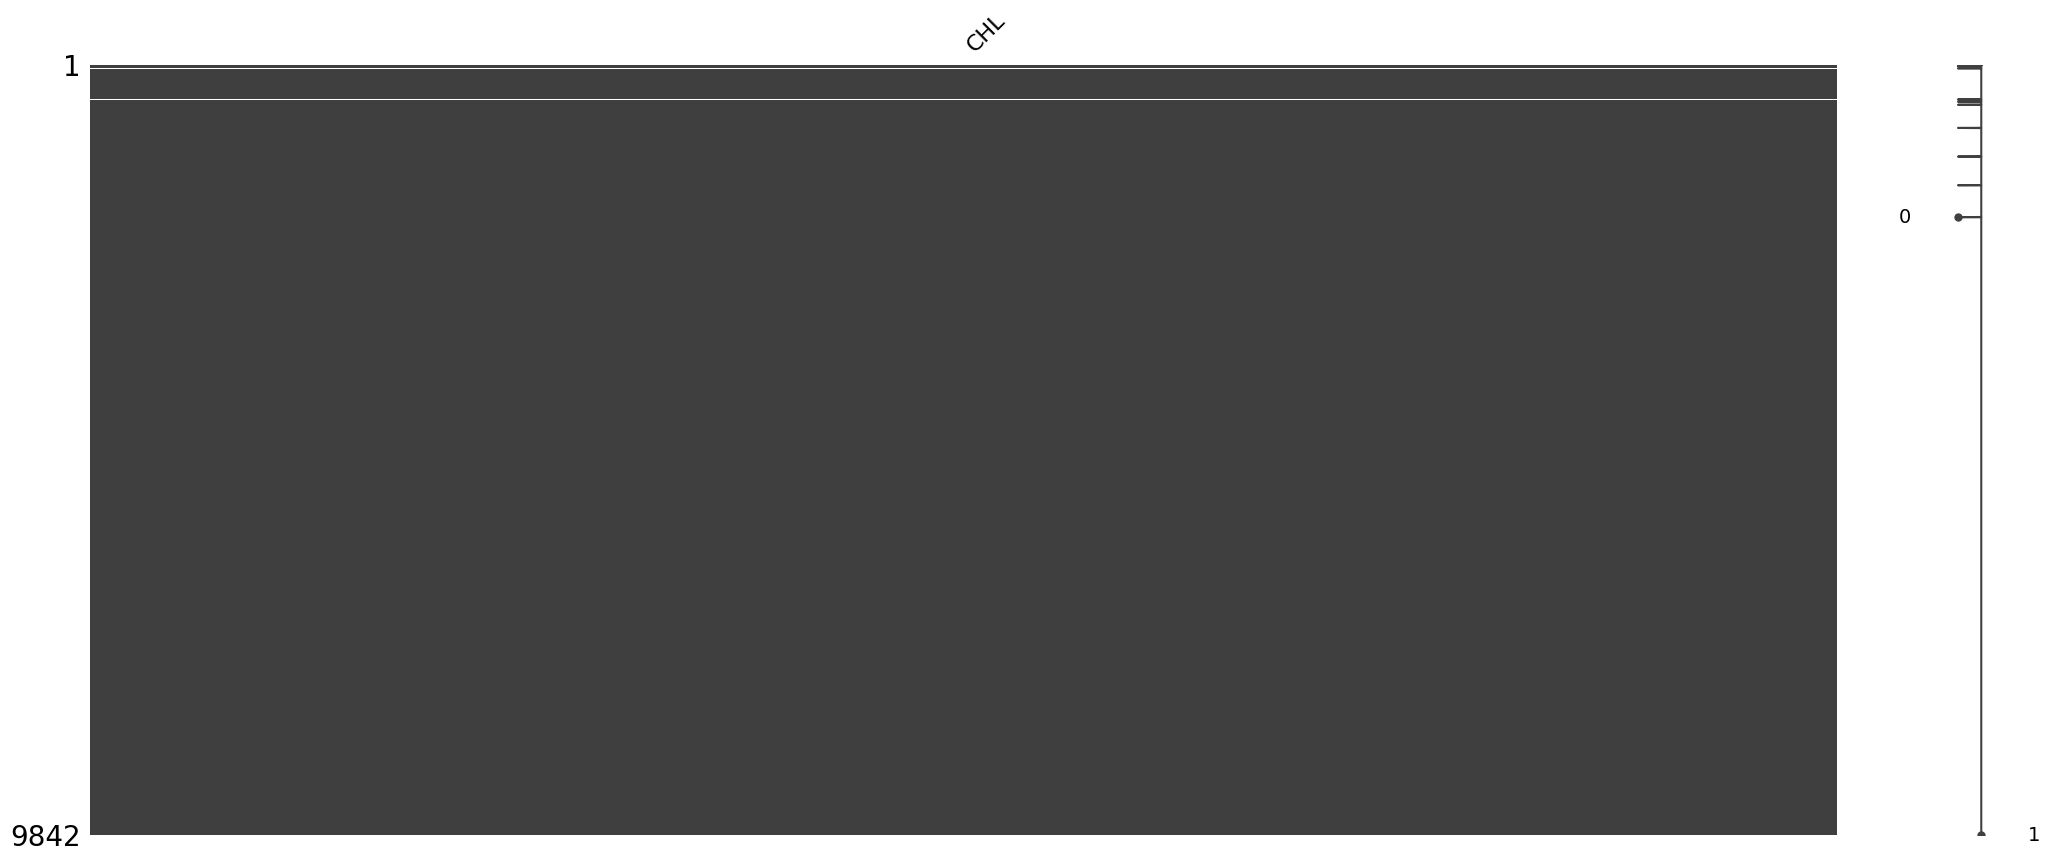

In [266]:
df = pd.DataFrame({"CHL": chl_np})

msno.matrix(df)
plt.show()

We note that the missing data are mainly at the beginning. Let's zoom in.

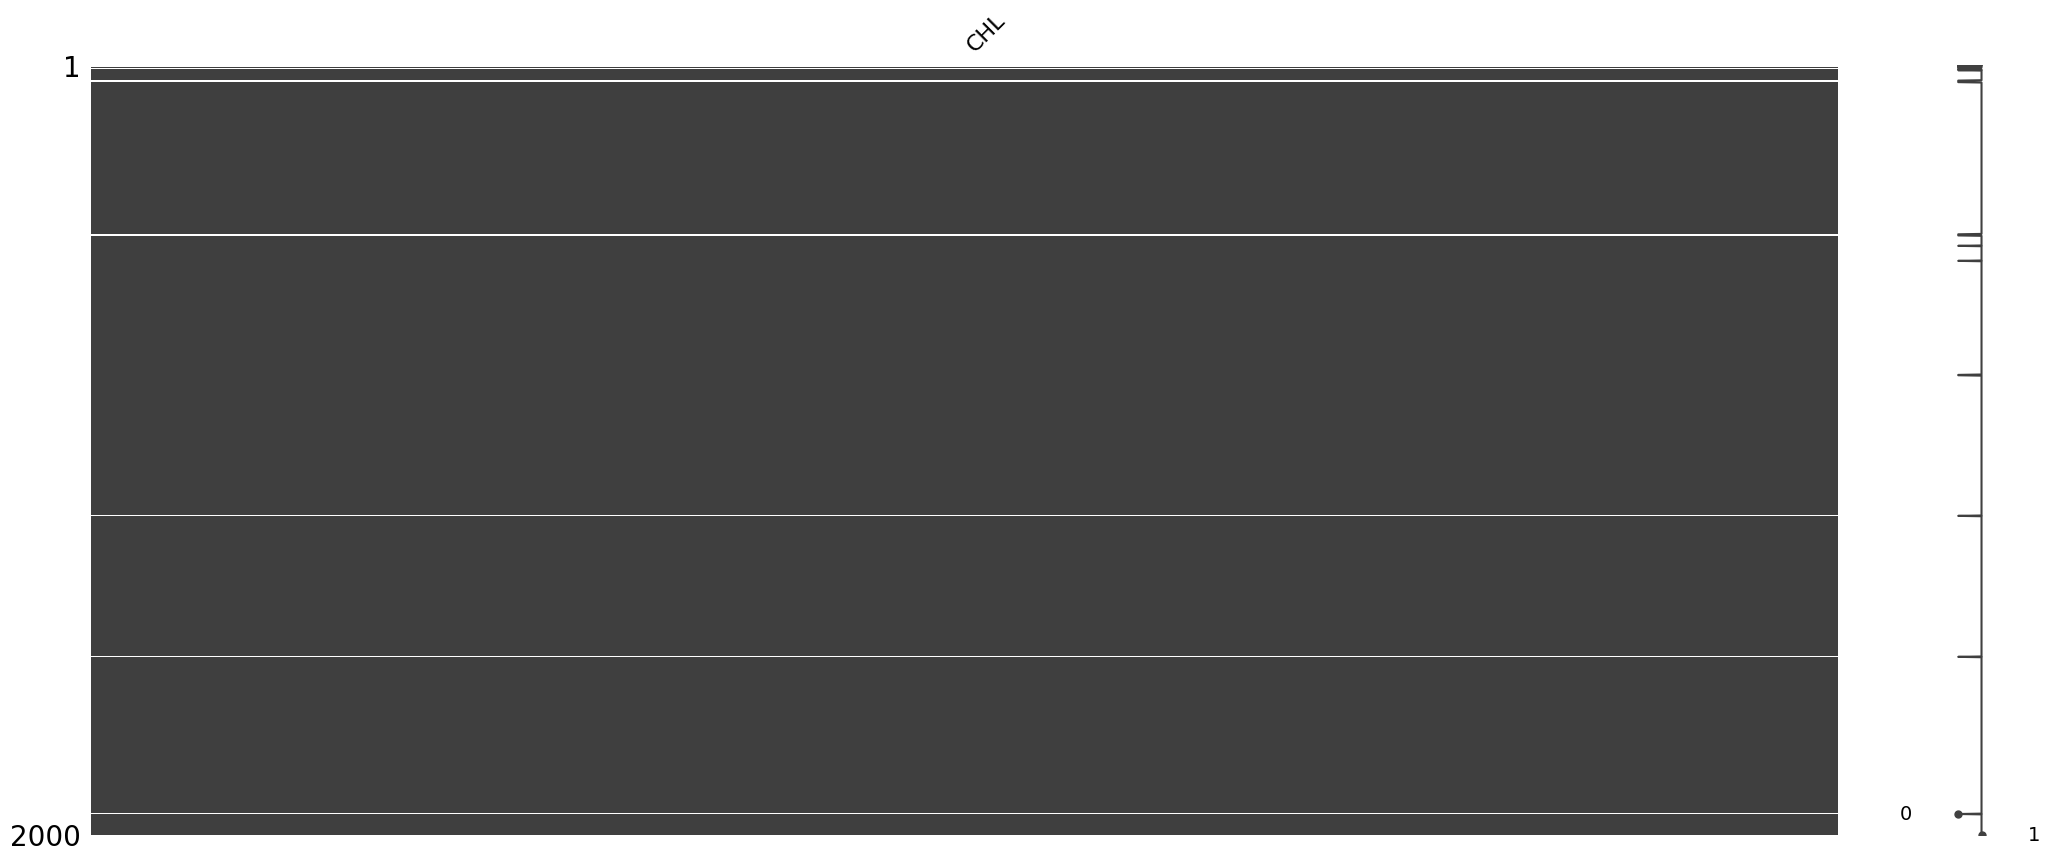

In [267]:
msno.matrix(df[:2000])
plt.show()

It can be seen that over the time series there are 24 occasions where there is no data. This may be due to the presence of clouds at the time of image acquisition.

In this case, since there are so few missing values, the values can be interpolated. For the sake of speed and simplicity, linear interpolation will be used. If this is found to affect the result, one can switch to a more robust interpolation, such as spline or linear RBF, albeit sacrificing more computational time for such a small amount of data.

Furthermore, one could use the methods mentioned in the paper [Ferreira, 2021](https://doi.org/10.3390/rs13040675), which mention the 3-step gap-filling algorithm [Sasaoka, 2011](https://doi.org/10.1016/j.rse.2014.05.016), and the 3-week centred moving mean algorithm [Ferreira, 2014](https://doi.org/10.1002/2014JC010323). These methods could be implemented in the future to improve the analysis.

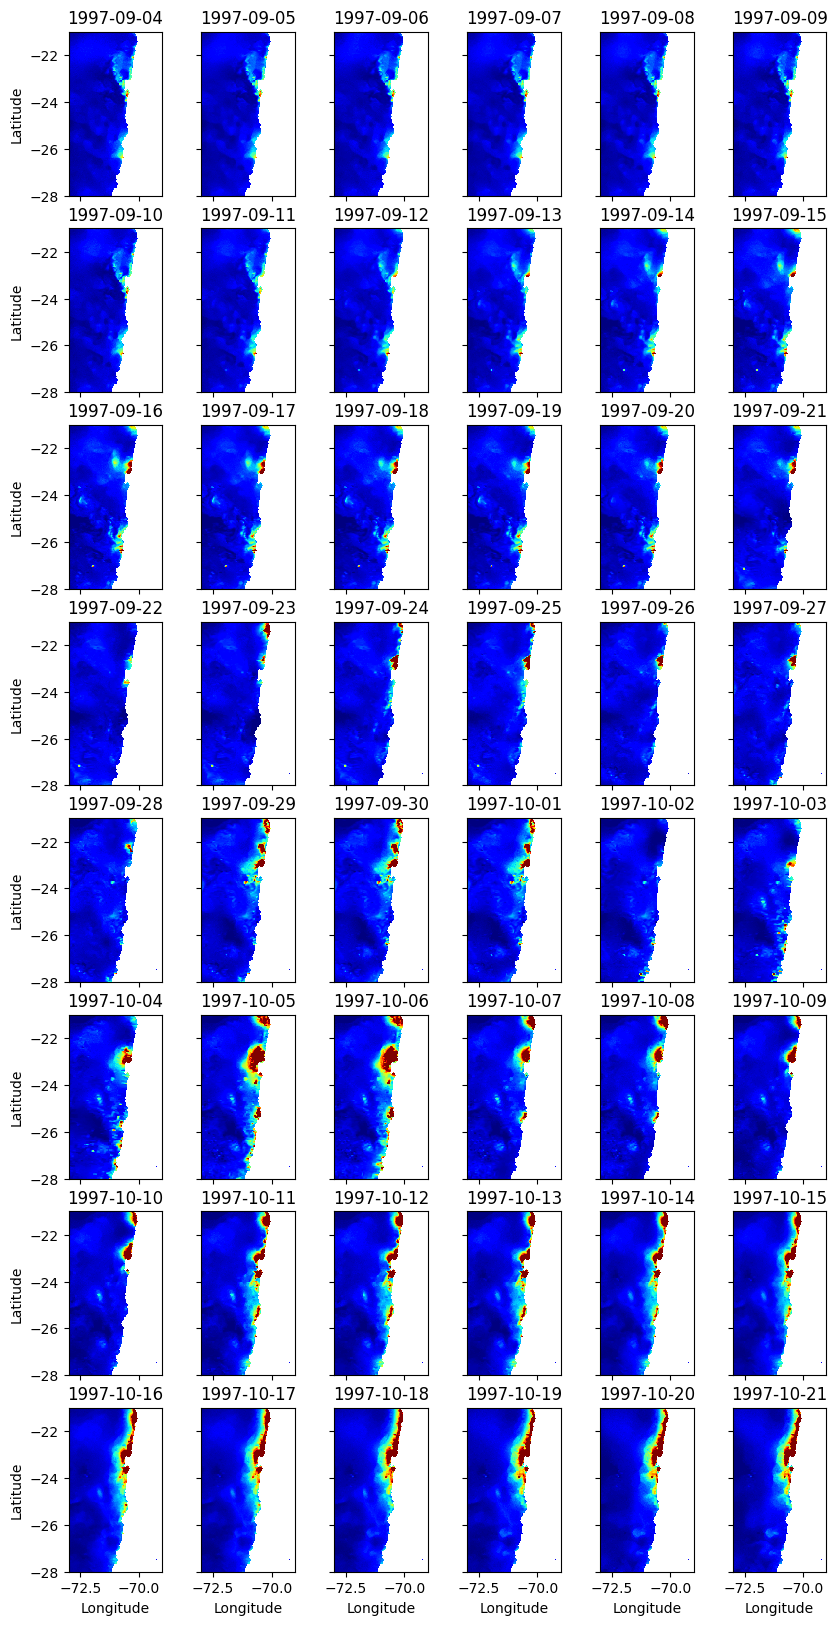

In [268]:
# interpolate nan
ds = ds.interpolate_na(dim="time", method="linear")

plot_chlorophyll_grid(ds, n_row=8, n_col=6)
plt.show()

Following the instructions, a region around the point $(-24.63, -70.40)$ will be selected. This change will improve processing speed in the future.

In [269]:
# Select a region around the coordinates (-23.627534, -70.396026)
delta = 2
lat, lon = -23.627534, -70.396026
lon_min, lon_max = lon - delta, lon + delta
lat_min, lat_max = lat - delta, lat + delta
ds = ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

The coastal region will also be eliminated as it does not provide relevant information for the analysis.

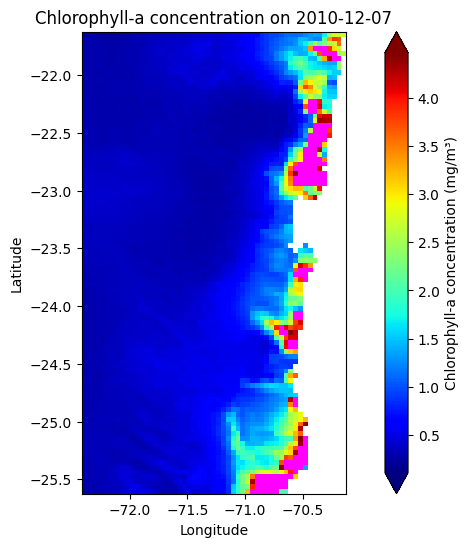

In [272]:
lon_max = ds.lon.where(~np.isnan(ds.CHL[0, :, :])).max()

ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

plot_chlorophyll(ds, -5000)
plt.show()

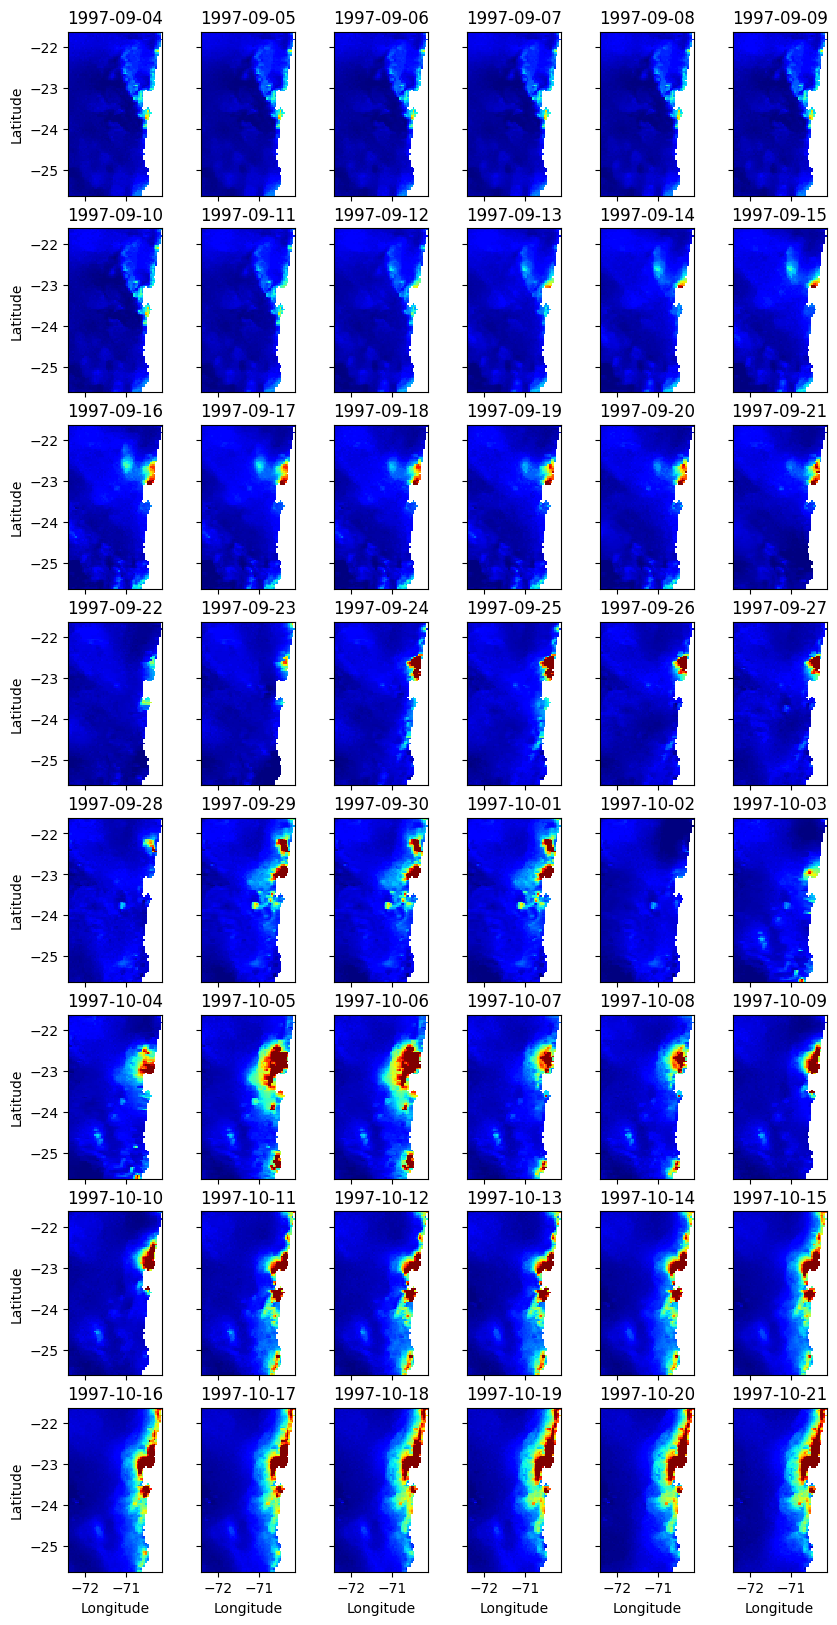

In [273]:
plot_chlorophyll_grid(ds, n_row=8, n_col=6)
plt.show()

Finally, the remaining null values must be kept as they are. They cannot be interpolated, as these data are from the coast, nor can they be replaced by some other value, as it may lead to erroneous conclusions in the future. It is best to create a mask for these values.

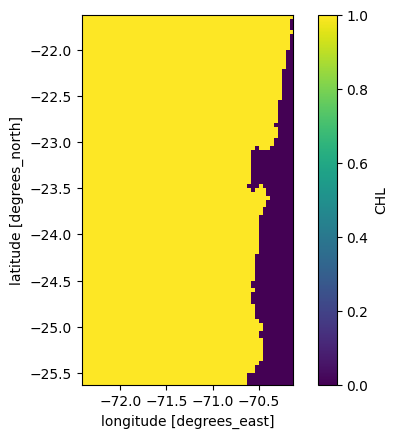

In [274]:
mask = ds.CHL.notnull().all(dim="time")
fig, ax = plt.subplots()
mask.plot()
# equal axis
ax.set_aspect("equal", adjustable="box")

Finally, the time series will be cut to start from 1 January 1998, because the metrics are calculated annually.

In [276]:
ds = ds.sel(time=slice("1998-01-01", None))
ds

<xarray.Dataset> Size: 205MB
Dimensions:  (lat: 96, lon: 55, time: 9723)
Coordinates:
  * lat      (lat) float32 384B -25.6 -25.56 -25.52 ... -21.73 -21.69 -21.65
  * lon      (lon) float32 220B -72.4 -72.35 -72.31 ... -70.23 -70.19 -70.15
  * time     (time) datetime64[ns] 78kB 1998-01-01 1998-01-02 ... 2024-08-14
Data variables:
    CHL      (time, lat, lon) float32 205MB 0.1862 0.1848 ... 0.4265 0.4533
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    ...                              ...
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-11-20T15:24:55Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l4-gapf...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0
    copernicusmarine_version:        1.3.2

In [16]:
print(ds)

<xarray.Dataset> Size: 470MB
Dimensions:  (lat: 168, lon: 71, time: 9842)
Coordinates:
  * lat      (lat) float32 672B -27.98 -27.94 -27.9 ... -21.1 -21.06 -21.02
  * lon      (lon) float32 284B -72.98 -72.94 -72.9 ... -70.15 -70.1 -70.06
  * time     (time) datetime64[ns] 79kB 1997-09-04 1997-09-05 ... 2024-08-14
Data variables:
    CHL      (time, lat, lon) float32 470MB 0.271 0.2744 0.2608 ... nan nan nan
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    ...                              ...
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-11-20T15:24:55Z
    title:                           

In [17]:
xr.where(
    ds.CHL[0, :, :] > 0,
    ds.CHL[0, :, :].where(mask),
    ds.CHL[0, :, :].where(~mask),
)

<xarray.DataArray 'CHL' (lat: 168, lon: 71)> Size: 48kB
array([[0.2710078 , 0.2743642 , 0.26078647, ...,        nan,        nan,
               nan],
       [0.25192034, 0.2556529 , 0.258156  , ...,        nan,        nan,
               nan],
       [0.2513208 , 0.25283852, 0.25781697, ...,        nan,        nan,
               nan],
       ...,
       [0.24339126, 0.2589503 , 0.24339126, ..., 0.54272026,        nan,
               nan],
       [0.24261169, 0.25811723, 0.24279766, ...,        nan,        nan,
               nan],
       [0.2403522 , 0.22610025, 0.24031487, ...,        nan,        nan,
               nan]], shape=(168, 71), dtype=float32)
Coordinates:
  * lat      (lat) float32 672B -27.98 -27.94 -27.9 ... -21.1 -21.06 -21.02
  * lon      (lon) float32 284B -72.98 -72.94 -72.9 ... -70.15 -70.1 -70.06
    time     datetime64[ns] 8B 1997-09-04

In [35]:
chl_np[0]

array([[0.2710078 , 0.2743642 , 0.26078647, ...,        nan,        nan,
               nan],
       [0.25192034, 0.2556529 , 0.258156  , ...,        nan,        nan,
               nan],
       [0.2513208 , 0.25283852, 0.25781697, ...,        nan,        nan,
               nan],
       ...,
       [0.24339126, 0.2589503 , 0.24339126, ..., 0.54272026,        nan,
               nan],
       [0.24261169, 0.25811723, 0.24279766, ...,        nan,        nan,
               nan],
       [0.2403522 , 0.22610025, 0.24031487, ...,        nan,        nan,
               nan]], shape=(168, 71), dtype=float32)

In [ ]:
chl_da = ds["CHL"]
chl_np = chl_da.values

mask_np = np.isnan(chl_np[0, :, :])
# Unsquezeze the first dimension
mask_np = mask_np[np.newaxis, :, :]
mask_np = np.repeat(mask_np, chl_np.shape[0], axis=0)

chl_np = np.ma.masked_array(chl_np, mask=mask_np)
chl_np

masked_array(
  data=[[[0.27100780606269836, 0.2743642032146454, 0.2607864737510681,
          ..., --, --, --],
         [0.25192034244537354, 0.25565290451049805, 0.2581560015678406,
          ..., --, --, --],
         [0.25132080912590027, 0.25283852219581604, 0.25781697034835815,
          ..., --, --, --],
         ...,
         [0.2433912605047226, 0.25895029306411743, 0.2433912605047226,
          ..., 0.5427202582359314, --, --],
         [0.24261169135570526, 0.2581172287464142, 0.24279765784740448,
          ..., --, --, --],
         [0.24035219848155975, 0.22610025107860565, 0.24031487107276917,
          ..., --, --, --]],

        [[0.25958478450775146, 0.263288676738739, 0.26659059524536133,
          ..., --, --, --],
         [0.25742924213409424, 0.2527705729007721, 0.2558615207672119,
          ..., --, --, --],
         [0.24888336658477783, 0.2510591447353363, 0.24752560257911682,
          ..., --, --, --],
         ...,
         [0.24492555856704712, 0.253021717

In [46]:
# Get the total of na values in chl_np
total_na = chl_np.mask.sum()
total_na

np.int64(19270636)

In [41]:
mask_np

array([[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]]],
      shape=(1, 168, 71))

In [ ]:
df = pd.DataFrame({"CHL": chl_np.flatten()})

msno.matrix(df)
plt.show()

In [73]:
df.isna().sum()

CHL    24
dtype: int64

In [ ]:
# See if there are any NaN values that are not masked
(ds.isnull().sum().CHL.values - (~mask).sum().values * ds.time.size)

np.int64(-9623)

In [58]:
ds

<xarray.Dataset> Size: 470MB
Dimensions:  (lat: 168, lon: 71, time: 9842)
Coordinates:
  * lat      (lat) float32 672B -27.98 -27.94 -27.9 ... -21.1 -21.06 -21.02
  * lon      (lon) float32 284B -72.98 -72.94 -72.9 ... -70.15 -70.1 -70.06
  * time     (time) datetime64[ns] 79kB 1997-09-04 1997-09-05 ... 2024-08-14
Data variables:
    CHL      (time, lat, lon) float32 470MB 0.271 0.2744 0.2608 ... nan nan nan
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    ...                              ...
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-11-20T15:24:55Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l4-gapf...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0
    copernicusmarine_version:        1.3.2

In [63]:
~mask

<xarray.DataArray 'CHL' (lat: 168, lon: 71)> Size: 12kB
array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]], shape=(168, 71))
Coordinates:
  * lat      (lat) float32 672B -27.98 -27.94 -27.9 ... -21.1 -21.06 -21.02
  * lon      (lon) float32 284B -72.98 -72.94 -72.9 ... -70.15 -70.1 -70.06
    time     datetime64[ns] 8B 1997-09-04

In [49]:
# Get the total of na values in chl_np as an int
ds: xr.Dataset
ds.CHL.isnull().sum().values

array(19261013)

In [65]:
(~mask).sum().values * ds.time.size

np.int64(19270636)

In [68]:
(~mask).sum().values

array(1958)

In [48]:
ds.time.size

9842

In [69]:
ds.CHL.isnull().sum().values / ds.time.size

np.float64(1957.022251574883)

In [29]:
# ds = ds.resample(time="1D").mean(dim="time")

# Select a region around the coordinates (-23.627534, -70.396026)
# delta = 1
# lat, lon= -23.627534, -70.396026
# lon_min, lon_max = lon - delta, lon + delta
# lat_min, lat_max = lat - delta, lat + delta
# ds = ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))